In [1]:
import pandas as pd
from pandasql import sqldf
import boto3
import json
import os
# python -m spacy download en
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from keras import models, layers
# from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import LabelBinarizer
# import numpy as np
from keras.utils import to_categorical
# from keras.models import Sequential
# from keras.layers import Dense
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
import matplotlib.pyplot as plt
import copy
import numpy as np
from keras.preprocessing.text import Tokenizer
%run '../extra_fns.ipynb'


Using TensorFlow backend.


In [2]:
with open('../boto-config.json') as json_data:
    boto_config = json.load(json_data)
    
s3 = boto3.client(
    's3',
    aws_access_key_id=boto_config['aws_access_key_id'],
    aws_secret_access_key=boto_config['aws_secret_access_key']
)

In [3]:
data_dir = 'data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
src_file = data_dir + '/News_Category_Dataset.json'
src_file_cleaned = data_dir + '/News_Clean.csv'

# s3.upload_file(src_file, boto_config['buckets']['kaggle'], src_file)
# s3.upload_file(src_file_cleaned, boto_config['buckets']['kaggle'], src_file_cleaned)

# s3.download_file(boto_config['buckets']['kaggle'], src_file, src_file)
# s3.download_file(boto_config['buckets']['kaggle'], src_file_cleaned, src_file_cleaned)

In [4]:
# data = pd.read_json(src_file, lines=True)
df = pd.read_csv(src_file_cleaned)
df = df[~df.clean_text.isnull()]

In [ ]:
data.describe()

In [ ]:
data.head()

In [ ]:
data.isnull().values.any()

In [ ]:
data.columns

In [ ]:
data.shape

In [ ]:
# clean up text
nlp = spacy.load('en')

data['text'] = data['headline'] + ' ' + data['short_description']

docs = data['text'].tolist()

def token_filter(token):
    return not (token.is_punct | token.is_space | token.is_stop | len(token.text) <= 3)

filtered_tokens = []
for doc in nlp.pipe(docs):
    tokens = [token.lemma_ for token in doc if token_filter(token) and token.text not in STOP_WORDS]
    filtered_tokens.append(' '.join(tokens))

data['clean_text'] = filtered_tokens

data.to_csv(src_file_cleaned, index=False)

In [7]:
sqldf("""select category, count(*) from df group by 1 order by 2 desc""")

,category,count(*)
0,POLITICS,32738
1,ENTERTAINMENT,14255
2,HEALTHY LIVING,6691
3,QUEER VOICES,4994
4,BUSINESS,4253
5,SPORTS,4166
6,COMEDY,3966
7,PARENTS,3955
8,BLACK VOICES,3858
9,THE WORLDPOST,3664


In [8]:
# tfidf with sklearn
tfidf = TfidfVectorizer()

bag = tfidf.fit_transform(df.loc[:, 'clean_text'])

In [5]:
lbler = LabelEncoder()
labels = to_categorical(lbler.fit_transform(df['category']))
num_labels = labels.shape[1]

In [10]:
train = tfidf.transform(df.loc[:, 'clean_text'])

In [11]:
# train, test validation
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size = 0.2, random_state = 1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 1)

In [11]:
# nn with keras
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_labels, activation='softmax'))

In [12]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               512256    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 31)                2015      
Total params: 555,423
Trainable params: 555,423
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(X_train, y_train, epochs = 10, batch_size=512, validation_data=(X_val, y_val))

Train on 89978 samples, validate on 9998 samples
Epoch 1/10
89978/89978 [==============================] - 2s 20us/step - loss: 2.2307 - acc: 0.4164 - val_loss: 1.8722 - val_acc: 0.4996
Epoch 2/10
89978/89978 [==============================] - 1s 15us/step - loss: 1.7055 - acc: 0.5321 - val_loss: 1.7372 - val_acc: 0.5281
Epoch 3/10
89978/89978 [==============================] - 1s 13us/step - loss: 1.5551 - acc: 0.5647 - val_loss: 1.7155 - val_acc: 0.5313
Epoch 4/10
89978/89978 [==============================] - 1s 12us/step - loss: 1.4541 - acc: 0.5869 - val_loss: 1.7018 - val_acc: 0.5367
Epoch 5/10
89978/89978 [==============================] - 1s 12us/step - loss: 1.3640 - acc: 0.6068 - val_loss: 1.7069 - val_acc: 0.5375
Epoch 6/10
89978/89978 [==============================] - 1s 14us/step - loss: 1.2768 - acc: 0.6298 - val_loss: 1.7270 - val_acc: 0.5374
Epoch 7/10
89978/89978 [==============================] - 1s 13us/step - loss: 1.1878 - acc: 0.6537 - val_loss: 1.7628 - val_acc:

Max Val Accuracy 0.5375075012022172 on Epoch 4


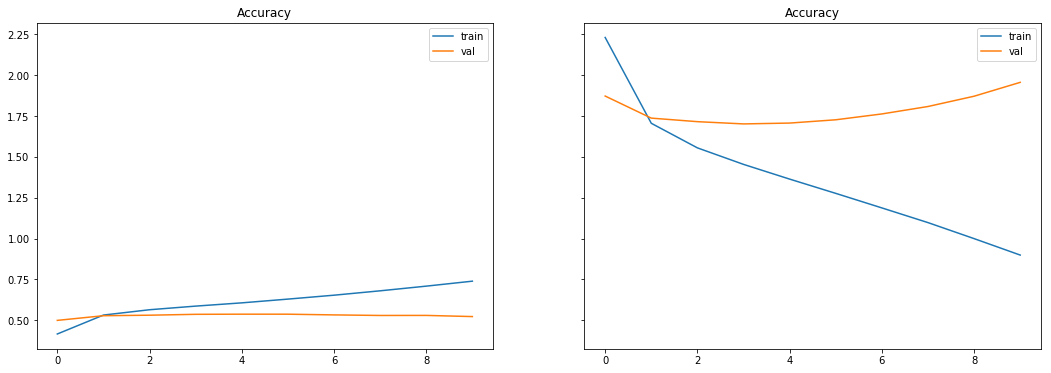

In [15]:
evaluate_nn(history)

In [49]:
model.evaluate(X_test, y_test)

24994/24994 [==============================] - 1s 23us/step


[2.1182739689434644, 0.529367048091542]

In [38]:
test_labels = np.argmax(y_test, axis=1)
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hist_array = np.array(test_labels_copy) == np.array(test_labels)
float(np.sum(hist_array))/len(hist_array)

0.1003040729775146

In [6]:
tk = Tokenizer(num_words = 2000)

In [7]:
tk.fit_on_texts(df.clean_text)

In [8]:
train = tk.texts_to_matrix(df.clean_text, mode='binary')

In [9]:
train.shape

(124970, 2000)

In [10]:
# train, test validation
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size = 0.2, random_state = 1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 1)